In [ ]:
import cv2
import os
from tqdm.notebook import tqdm
import numpy as np
np.random.seed(43)
 
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
 
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
 
import torch
torch.manual_seed(43)
import torch.nn as nn
import torch.nn.functional as F
 
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, RandomSampler
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/IIIT HYDERABAD/SEMESTER 6/CV/Assignment 5/train.zip" -d "/content/temp_train/"
!unzip "/content/drive/My Drive/IIIT HYDERABAD/SEMESTER 6/CV/Assignment 5/test.zip" -d "/content/temp_test/"

!mv "/content/temp_train/content/drive/MyDrive/CV_a5/train_images/" "/content/"
!mv "/content/temp_test/content/drive/MyDrive/CV_a5/test_images/" "/content/"

!cp "/content/drive/My Drive/IIIT HYDERABAD/SEMESTER 6/CV/Assignment 5/train.csv" "/content/"
!cp "/content/drive/My Drive/IIIT HYDERABAD/SEMESTER 6/CV/Assignment 5/test.csv" "/content/"
!cp "/content/drive/My Drive/IIIT HYDERABAD/SEMESTER 6/CV/Assignment 5/dataset_info.txt" "/content/"
!rm -r "/content/temp_train"
!rm -r "/content/temp_test"

Streaming output truncated to the last 5000 lines.
  inflating: /content/temp_train/content/drive/MyDrive/CV_a5/train_images/8d00a03172.jpg  
  inflating: /content/temp_train/content/drive/MyDrive/CV_a5/train_images/15a87d4817.jpg  
  inflating: /content/temp_train/content/drive/MyDrive/CV_a5/train_images/f44c29ece5.jpg  
  inflating: /content/temp_train/content/drive/MyDrive/CV_a5/train_images/45dba3fe97.jpg  
  inflating: /content/temp_train/content/drive/MyDrive/CV_a5/train_images/c756b82015.jpg  
  inflating: /content/temp_train/content/drive/MyDrive/CV_a5/train_images/0e2bdc7ba8.jpg  
  inflating: /content/temp_train/content/drive/MyDrive/CV_a5/train_images/b5cbc0056c.jpg  
  inflating: /content/temp_train/content/drive/MyDrive/CV_a5/train_images/10982b2133.jpg  
  inflating: /content/temp_train/content/drive/MyDrive/CV_a5/train_images/617b7641b3.jpg  
  inflating: /content/temp_train/content/drive/MyDrive/CV_a5/train_images/6601b6bd82.jpg  
  inflating: /content/temp_train/conten

In [ ]:
assign_path = "/content/"

train_path = assign_path + "train_images/"
train_csv = assign_path + "train.csv"
test_path = assign_path + "test_images/"
test_csv = assign_path + "test.csv"
class_info = assign_path + "dataset_info.txt"

In [ ]:
with open(class_info, 'r') as f:
    data = f.read()
    data = data.split('\n')[1:]
    classes = []
    for i in data:
        classes.append(i.split('.')[1].strip())

class2index = {c: i for i, c in enumerate(classes)}
index2class = {class2index[c]: c for c in class2index}

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, folder, class2index, transform=None):
        self.df = pd.read_csv(csv_path)
        self.folder = folder
        self.transform = transform
        self.class2index = class2index
        self.num = len(self.df)
 
    def __len__(self):
        return 5*len(self.df)
 
    def __getitem__(self, index):
        fname = self.df['ImageId'][index%self.num]
        label = self.class2index[self.df["ClassName"][index%self.num]]
        image = Image.open(os.path.join(self.folder, fname))
        if index // self.num == 1:
            image = image.transpose(Image.ROTATE_90)
        elif index // self.num == 2:
            image = image.transpose(Image.ROTATE_90).transpose(Image.ROTATE_90)
        elif index // self.num == 3:
            image = image.transpose(Image.FLIP_TOP_BOTTOM)
        elif index // self.num == 4:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
 
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128))
])

dataset = Dataset(train_csv, train_path, class2index, transform)

In [ ]:
val_size = int(0.1*len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device)

class DeviceLoader():
    def __init__(self, loader, device):
        self.loader = loader
        self.device = device

    def __iter__(self):
        for batch in self.loader:
            yield to_device(batch, self.device)

In [ ]:
def train(model, train_loader, val_loader, epochs, lr, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': []
    }

    min_val_loss = np.inf
    max_val_acc = 0
    for epoch in tqdm(range(epochs)):
        model.train()
        train_losses = []
        for i, batch in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            imgs, labs = batch
            out = model.forward(imgs)
            loss = nn.CrossEntropyLoss()(out, labs)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_losses = []
            val_accs = []
            for batch in tqdm(val_loader):
                imgs, labs = batch
                out = model.forward(imgs)
                loss = nn.CrossEntropyLoss()(out, labs)
                val_losses.append(loss)
                acc = accuracy(out, labs)
                val_accs.append(acc)
        
        history['train_loss'].append(torch.stack(train_losses).mean().item())
        history['val_loss'].append(torch.stack(val_losses).mean().item())
        history['val_acc'].append(torch.stack(val_accs).mean().item())

        if history['val_loss'][epoch] < min_val_loss:
            min_val_loss = history['val_loss'][epoch]
            torch.save(model, './best_loss_model')

        if history['val_acc'][epoch] > max_val_acc:
            max_val_acc = history['val_acc'][epoch]
            torch.save(model, './best_acc_model')
        
        print('Epoch: ' + str(epoch+1) + ', Train loss: ' + str(history['train_loss'][epoch])
                            + ', Validation loss: ' + str(history['val_loss'][epoch])
                            + ', Validation accuracy: ' + str(history['val_acc'][epoch]))
        
    return history

def accuracy(outputs, labels):
    softmax = nn.Softmax(dim=1)
    _, preds = torch.max(softmax(outputs), dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def plot_graphs(history):
    fig = plt.figure(figsize=(24, 8))

    # Train Loss and Validation loss
    axs = fig.add_subplot(121)
    no_ep = len(history['val_loss'])
    axs.plot(np.arange(no_ep)+1, history['train_loss'], label='Train Loss')
    axs.plot(np.arange(no_ep)+1, history['val_loss'], label='Val Loss')
    axs.set_title('Losses vs Epoch', fontsize=20)
    axs.xaxis.label.set_size(40)
    axs.set_xlabel('Epoch', fontsize=15)
    axs.set_ylabel('Loss', fontsize=15)
    axs.legend(fontsize=15)

    # Validation accuracy
    axs = fig.add_subplot(122)
    no_ep = len(history['val_acc'])
    axs.plot(np.arange(no_ep)+1, history['val_acc'])
    axs.set_title('Validation accuracy vs Epoch', fontsize=20)
    axs.set_xlabel('Epoch', fontsize=15)
    axs.set_ylabel('Validation accuracy', fontsize=15)

In [ ]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size, shuffle=True)

In [ ]:
train_dl = DeviceLoader(train_dl, device)
val_dl = DeviceLoader(val_dl, device)

In [ ]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(in_features, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 62)
)

In [ ]:
model
to_device(model, device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
num_epochs = 7
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = train(model, train_dl, val_dl, num_epochs, lr, opt_func)


Epoch: 1, Train loss: 2.4353864192962646, Validation loss: 2.0409910678863525, Validation accuracy: 0.4359895884990692



Epoch: 2, Train loss: 1.8594796657562256, Validation loss: 1.7375296354293823, Validation accuracy: 0.5047937035560608



Epoch: 3, Train loss: 1.642054796218872, Validation loss: 1.6205295324325562, Validation accuracy: 0.523798942565918



Epoch: 4, Train loss: 1.4801222085952759, Validation loss: 1.5195468664169312, Validation accuracy: 0.5381397008895874



Epoch: 5, Train loss: 1.33906888961792, Validation loss: 1.3948194980621338, Validation accuracy: 0.5731172561645508



Epoch: 6, Train loss: 1.199718713760376, Validation loss: 1.3637412786483765, Validation accuracy: 0.5876801609992981



Epoch: 7, Train loss: 1.073615312576294, Validation loss: 1.2636046409606934, Validation accuracy: 0.6095123291015625



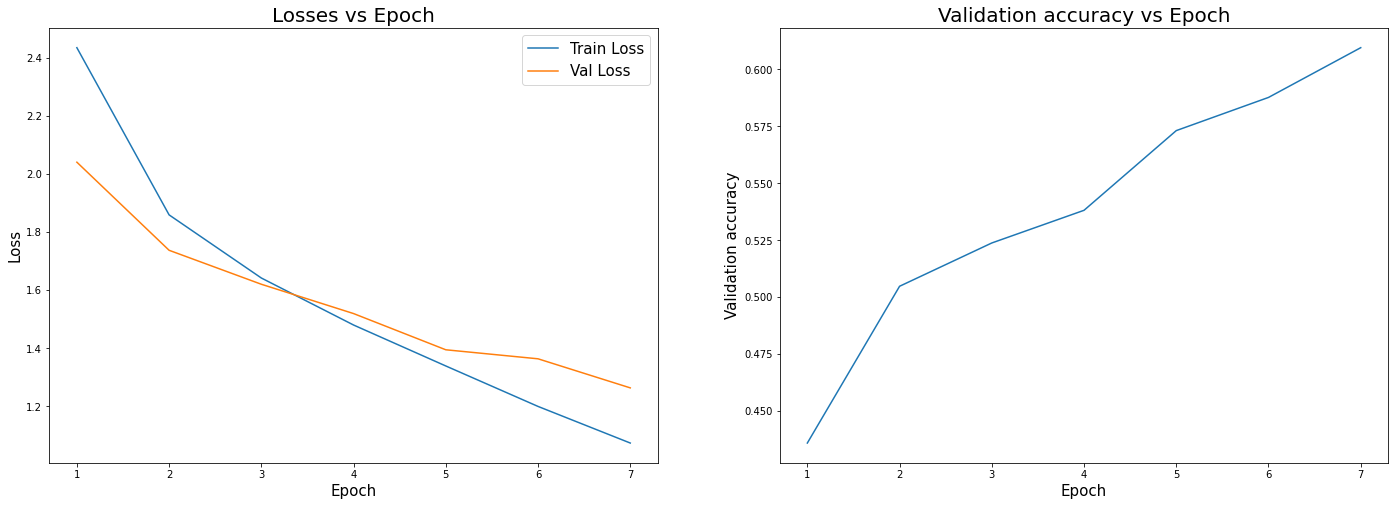

In [ ]:
plot_graphs(history)

In [ ]:
b_model = torch.load('./best_acc_model')

In [ ]:
def predict(img, model):
    x = to_device(img.unsqueeze(0), device)
    y = model.forward(x)
    _, preds = torch.max(y, dim=1)

    return index2class[preds[0].item()]

In [ ]:
with open(test_csv, 'r') as f:
    data = f.read()
    rows = data.split('\n')[1:-1]

In [ ]:
ts_out = []
for i in rows:
    im = Image.open(os.path.join(test_path, i))
    im = transform(im)
    lab = predict(im, model)
    ts_out.append([i, lab])

test_outputs = pd.DataFrame(ts_out, columns=['ImageId', 'ClassName'])
test_outputs.to_csv('submit.csv')